# Exploratory Data Analysis of the Abalone Data Set

In [1]:
import pandas as pd
import altair as alt
import numpy as np
# Handle large data sets without embedding them in the notebook
alt.data_transformers.enable('data_server')
# Gradescope only supports displaying plots as images
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

### 1. Basic data set information
Data comes from an original (non-machine-learning) study: Warwick J Nash, Tracy L Sellers, Simon R Talbot, Andrew J Cawthorn and Wes B Ford (1994) "The Population Biology of Abalone (_Haliotis_ species) in Tasmania. I. Blacklip Abalone (_H. rubra_) from the North Coast and Islands of Bass Strait", Sea Fisheries Division, Technical Report No. 48 (ISSN 1034-3288). In this research project, we are going to use physical and biological attributes of abalone to predict whether an abalone is old or young. There are 4177 observations in this data set and 8 features. We have sex as a categorical feature indicating whether an abalone is male, female or infant. We have other 7 numeric features which describe the size and weight of abalones. The missing values have been removed in the original research so we do not have missing values here.   
We set abalones with rings greater than 11 as old and less than 12 as young. This threshold is arbitrary.We can observe an unbalanced distribution of target variable.  

| Target  | Old | Young |
| --- | --- | --- |
| __Observations__ | 960 | 3217 |

Table 1. Counts of observations for each class

The data loading and head of data is shown below.

In [2]:
# Load data
df = pd.read_csv(
    "../../data/raw/abalone.data",
    names=[
        "Sex",
        "Length",
        "Diameter",
        "Height",
        "Whole weight",
        "Shucked weight",
        "Viscera weight",
        "Shell weight",
        "Rings",
    ],
    header=0,
)

# Add a classification target columns. If rings > 11, then classified as old
df["Is old"] = np.where(df["Rings"] > 11, "old", "young")
df.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Is old
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,old
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,young
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,young
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,young
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,young


### 2. Train, test split 
As we plan to do a prediction on whether an abalone is young or old, we create train, test set in (80:20) ratio before any data preprocessing. We create a training data which contains 3341 observations. The target observations in train, test set is shown in table 2.  

| Target  | Old | Young |
| --- | --- | --- |
| train | 765 | 2576 |
| test | 195 | 641 |

Table 2. Counts of observations for each class in train test split.

As we can see in the table, the unbalanced target variables should be coped with in future analysis.

In [3]:
# train test split
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)

### 3. Exploratory data analysis on training data set

#### 3.1 Target variable distribution
Exploratory data analysis gives us a basic understanding of our train data, and we may also find the some useful features to make young-old prediction for abalones. First, we plot the distribution of our target variable. The young-old class is derived from rings, so we also include the distribution of rings into our plot. From the figure we can observe a slightly right skewed distribution of `rings`. Since we set the threshold for old abalone as `rings > 11` , we get an unbalanced distribution of old and young abalone.

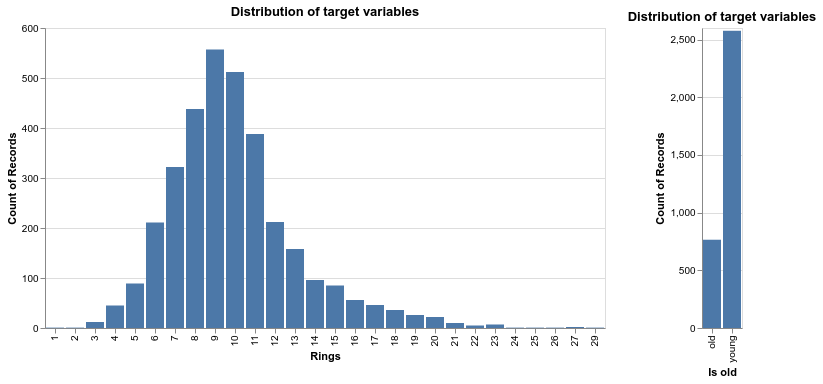

In [4]:
# Distribution of our target: rings and is_old
alt.Chart(train_df, title="Distribution of target variables").mark_bar().encode(
    alt.X(alt.repeat(), type="nominal"), alt.Y("count()")
).repeat(["Rings", "Is old"])

#### 3.2 Distribution of categorical variable
Sex is the only categorical variable in this data set. It has three categories: male, female and infant, denoted as M, F, I respectively. The distribution of sex is balanced.

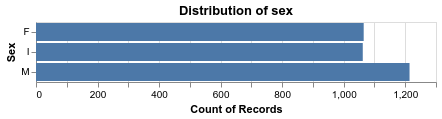

In [5]:
# Distribution of categorical variable: sex
alt.Chart(train_df, title="Distribution of sex").mark_bar().encode(
    alt.Y("Sex"), alt.X("count()")
)

#### 3.3 Distribution of continuous variables
We first get a summary table from our train data set. However, this table does not contain intuitive information to help us make prediction.

In [6]:
train_df.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000
mean,0.524779,0.408487,0.139885,0.830820,0.360402,0.181313,0.239490,9.938641
std,0.119631,0.098774,0.042666,0.489146,0.221692,0.109685,0.138806,3.240667
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.448000,0.188500,0.095000,0.131000,8.000000
50%,0.545000,0.425000,0.140000,0.800000,0.336000,0.171000,0.235000,9.000000
75%,0.615000,0.480000,0.165000,1.155000,0.505500,0.253500,0.330000,11.000000
max,0.800000,0.630000,1.130000,2.779500,1.488000,0.760000,1.005000,29.000000


Then we plot the distribution of all numeric features within two targeted classes.From the plot we can group the numeric variables into three groups: (length, diameter), (height), and (whole_weight, shucked_weight, viscera_weight, shell_weight).  
The first group is left skewed. The means of two classes are similar and the old abalones have less deviation from mean.The second group has some outliers and the third group is right skewed. In the third group, we can observe a difference in mean weights and the distribution of old abalones are more bell-shaped.

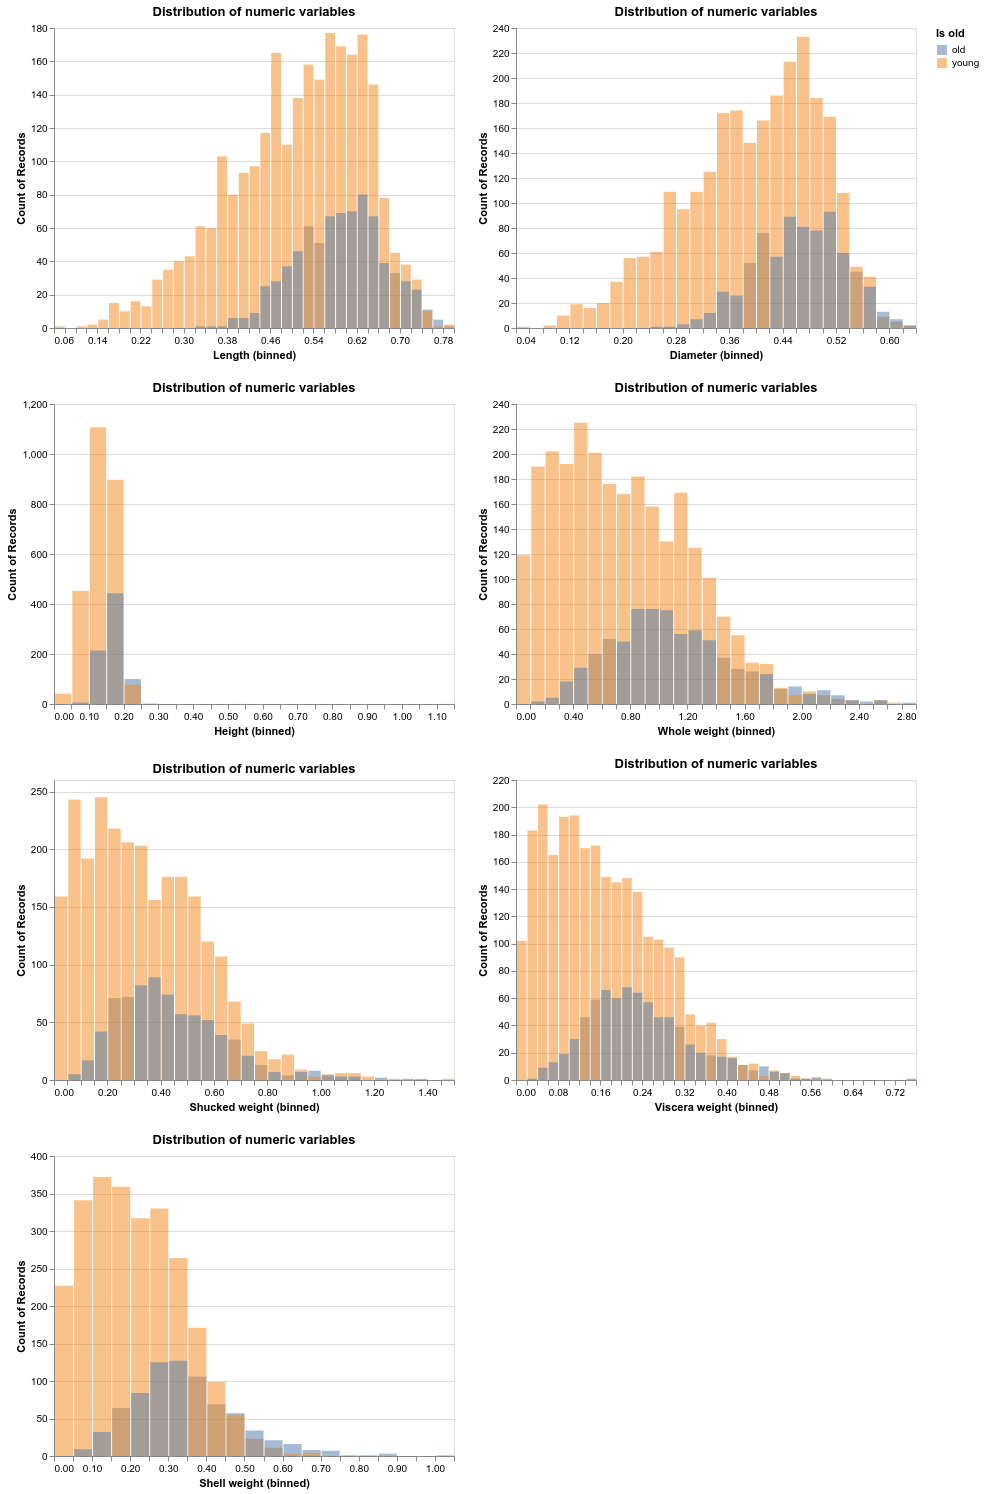

In [7]:
# Distribution of numeric variables: 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight'
alt.Chart(train_df, title="Distribution of numeric variables").mark_bar(
    opacity=0.5
).encode(
    alt.X(alt.repeat(), type="quantitative", bin=alt.Bin(maxbins=50)),
    alt.Y("count()", stack=None),
    color="Is old",
).repeat(
    [
        "Length",
        "Diameter",
        "Height",
        "Whole weight",
        "Shucked weight",
        "Viscera weight",
        "Shell weight",
    ],
    columns=2,
)

#### 3.4 Correlation of target variables and one feature variable from each group
We are also interested in how these three groups correlate with target variable rings and whether there is a difference in young and old abalones. We select length, height and whole weight as representatives. We can observe a difference in the regression line in two target classes when the predicting variables are length and whole weight.

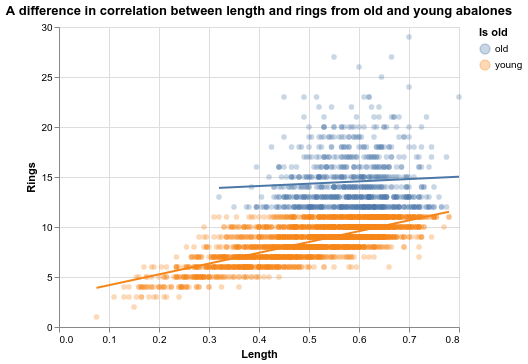

In [8]:
point_length = (
    alt.Chart(
        train_df,
        title="A difference in correlation between length and rings from old and young abalones",
    )
    .mark_circle(opacity=0.3)
    .encode(x=alt.X("Length"), y=alt.Y("Rings"), color="Is old")
)
point_length + point_length.transform_regression(
    "Length", "Rings", groupby=["Is old"]
).mark_line(color="red")

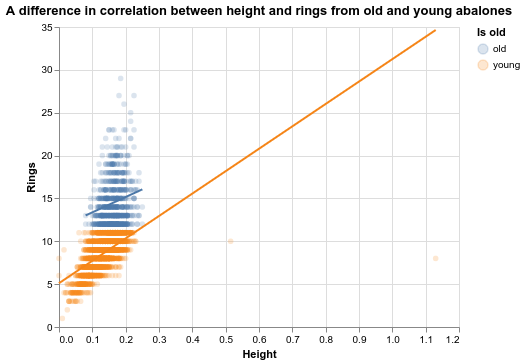

In [9]:
point_height = (
    alt.Chart(
        train_df,
        title="A difference in correlation between height and rings from old and young abalones",
    )
    .mark_circle(opacity=0.2)
    .encode(x=alt.X("Height"), y=alt.Y("Rings"), color="Is old")
)
point_height + point_height.transform_regression(
    "Height", "Rings", groupby=["Is old"]
).mark_line(color="red")

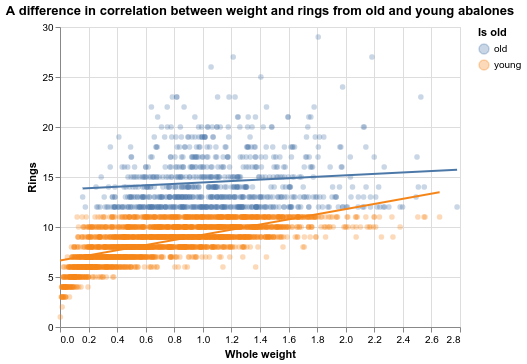

In [10]:
point_weight = (
    alt.Chart(
        train_df,
        title="A difference in correlation between weight and rings from old and young abalones",
    )
    .mark_circle(opacity=0.3)
    .encode(x=alt.X("Whole weight"), y=alt.Y("Rings"), color="Is old")
)
point_weight + point_weight.transform_regression(
    "Whole weight", "Rings", groupby=["Is old"]
).mark_line(color="red")

#### 3.5 Scatter plots showing the relationship between continuous features
We can expect colinearity in our numeric features. The size features (length, diameter and height) are correlated and size is correlated with weight. We may want to be extra careful when we want to implement models which are sensitive to highly correlated features. From the first group of scatter plots, we can tell that length, diameter and height are linearly correlated. The correlation between size and weight is more non-linear. From the second group of scatter plots, we find that feature of weight are correlated, but the correlations are not as strong as correlation in size features. The relationship between weight and age is hard to tell. Roughly, it is a positive relation.

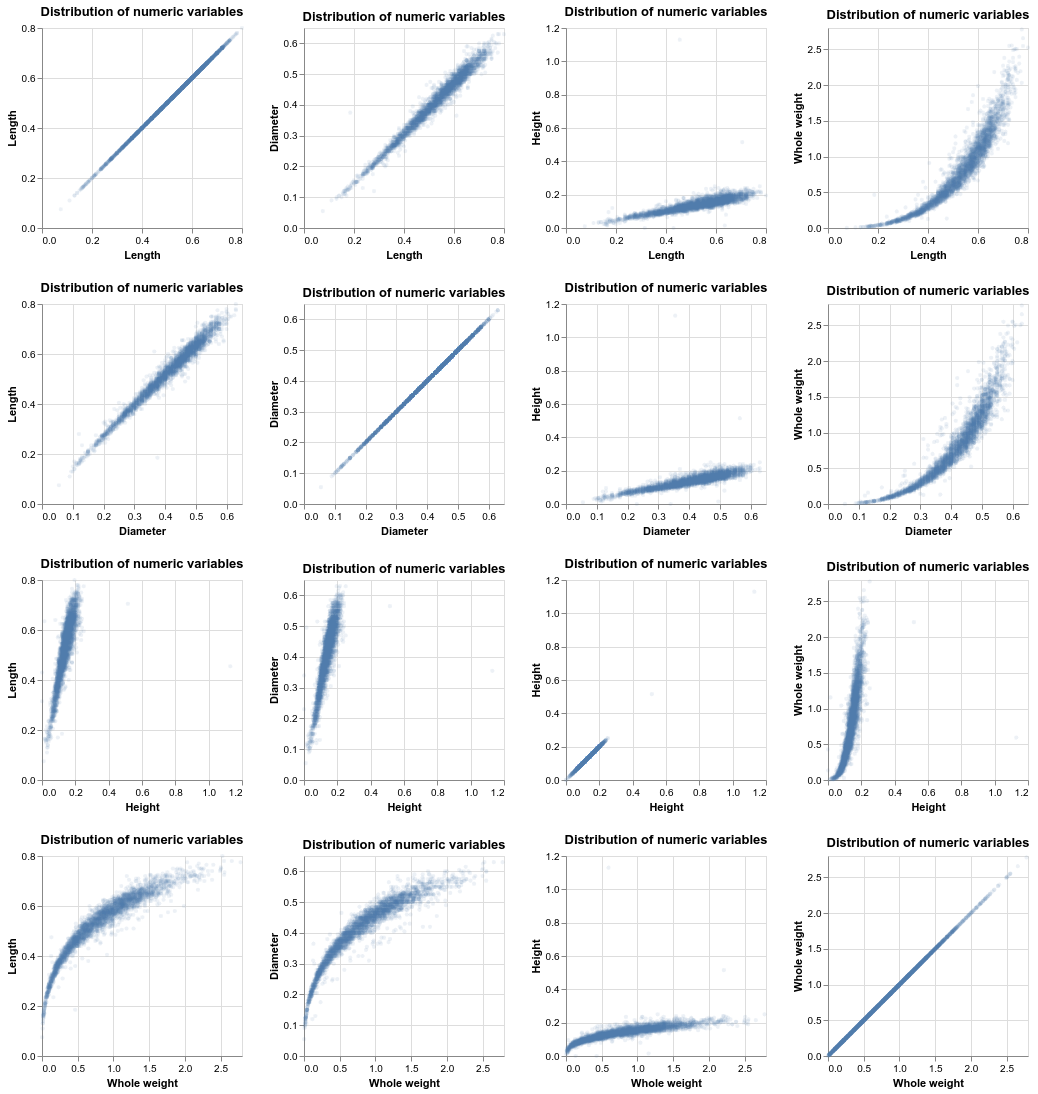

In [11]:
features = ["Length", "Diameter", "Height", "Whole weight"]

alt.Chart(train_df, title="Distribution of numeric variables").mark_point(
    size=5, opacity=0.1
).encode(
    alt.X(alt.repeat("row"), type="quantitative"),
    alt.Y(alt.repeat("column"), type="quantitative"),
).properties(
    height=200, width=200
).repeat(
    column=features, row=features, columns=2
)

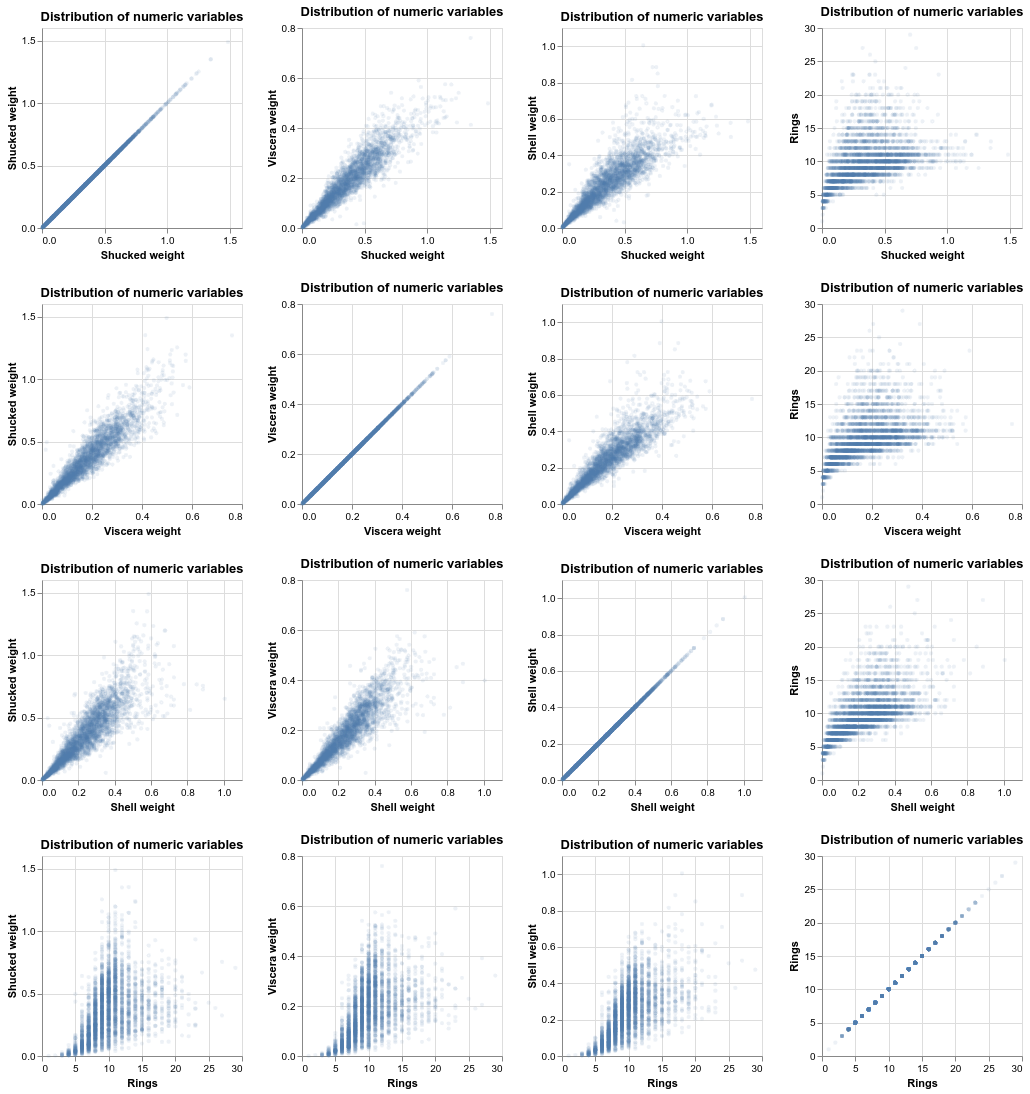

In [12]:
features = ["Shucked weight", "Viscera weight", "Shell weight", "Rings"]
alt.Chart(train_df, title="Distribution of numeric variables").mark_point(
    size=5, opacity=0.1
).encode(
    alt.X(alt.repeat("row"), type="quantitative"),
    alt.Y(alt.repeat("column"), type="quantitative"),
).properties(
    height=200, width=200
).repeat(
    column=features, row=features, columns=2
)

#### 3.6 Correlation heat map
A correlation heat map provides us with more visually intuitive relationship between all variables. From the heat map we can tell that feature variables are highly correlated.

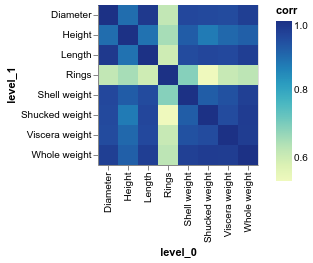

In [13]:
# check colinearity in features
corr_df = (
    train_df.drop(["Sex", "Is old"], axis=1)
    .corr("spearman")
    .abs()
    .stack()
    .reset_index(name="corr")
)
alt.Chart(corr_df).mark_rect().encode(
    x="level_0", y="level_1", size="corr", color="corr"
)

# References


_Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science._  

_Warwick J Nash, Tracy L Sellers, Simon R Talbot, Andrew J Cawthorn and Wes B Ford (1994) "The Population Biology of Abalone (_Haliotis_ species) in Tasmania. I. Blacklip Abalone (_H. rubra_) from the North Coast and Islands of Bass Strait", Sea Fisheries Division, Technical Report No. 48 (ISSN 1034-3288)_